
CHESS GAME ANALYSIS
===================


This notebook is where all the analysis happens. After collecting the raw data
with my Python script, I will use this interactive environment to clean the data,
explore it, create visualizations, test the hypotheses, and eventually build
a machine learning model.

-------------

### WHAT IT DOES:


1.  **Load and Clean:** It starts by loading 'chess_games_raw.csv' file
    and preparing it for analysis (e.g., converting dates).
2.  **Explore and Visualize:** I'll create plots and tables to answer the
    research questions about performance, playing style, and more.
3.  **Test Hypotheses:** I'll run statistical tests to see if my
    hunches (like the advantage of playing White) are backed by data.
4.  **Build a Model:** In the final section, I'll use this notebook to
    train a machine learning model to predict game outcomes.

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

## 1. Data Loading and Cleaning

My raw data is in a CSV file, but it needs significant preparation before I can trust the analysis.

**My Data Cleaning Checklist:**
1.  **Date Conversion:** The `date` column is currently text. I need to convert it to a `datetime` object to allow for time-series plotting.
2.  **Chronological Sorting:** I will sort the data by `timestamp` to ensure my rating history flows correctly from the past to the present.
3.  **Summer 2025 Filter:** My dataset contains old games from 2017. To keep this project focused on my recent "Summer Chess Journey," I will filter for games played after **June 1st, 2025**.
4.  **Game Mode Consistency:** Chess ratings vary wildly between "Daily" (days per move) and "Rapid" (10 minutes). To ensure my rating analysis is scientifically valid, I will filter to keep only **Rapid (10 min)** games and drop inconsistent data.

In [179]:
# First, I'll load the raw data.
df = pd.read_csv('data/chess_games_raw.csv')

# I'll check the initial state. 'date' will likely be type 'object' (text).
print("Initial Data Types:")
print(df.dtypes[['date', 'timestamp', 'my_rating']])
print("-" * 30)

# --- CLEANING STEP ---

# 1. Convert 'date' from text to datetime objects.
# This allows libraries like Matplotlib to understand the chronological order.
df['date'] = pd.to_datetime(df['date'])

# 2. Sort the data chronologically.
# I'll use the 'timestamp' column which is a precise number (Unix time).
# This ensures that my rating graph flows correctly from left to right.
df = df.sort_values(by='timestamp')

# 3. Reset the index.
# After sorting, the row numbers get jumbled. This makes them clean (0, 1, 2...) again.
df = df.reset_index(drop=True)

# --- VERIFICATION ---

# Now I'll check the types again to confirm 'date' is now 'datetime64[ns]'.
print("\nCleaned Data Types:")
print(df.dtypes[['date', 'timestamp', 'my_rating']])

# Let's see the first few rows to make sure it looks right.
df.head()

Initial Data Types:
date         object
timestamp     int64
my_rating     int64
dtype: object
------------------------------

Cleaned Data Types:
date         datetime64[ns]
timestamp             int64
my_rating             int64
dtype: object


,timestamp,url,date,my_color,my_rating,opponent_username,opponent_rating,outcome,time_control,time_class,opening,number_of_moves,pgn
0,1513657463,https://www.chess.com/game/live/2497776079,2017-12-19,white,652,shashankgautam,854,loss,600,NaN,Queens Pawn Opening Horwitz Defense 2.Bf4,21,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
1,1751096347,https://www.chess.com/game/daily/832476674,2025-06-28,black,254,zaar_m,546,loss,1/86400,NaN,Kings Pawn Opening Kings Knight Variation,39,"[Event ""Let's Play!""]\n[Site ""Chess.com""]\n[Da..."
2,1751117544,https://www.chess.com/game/live/140107992838,2025-06-28,white,423,LouisSchne,203,win,600,NaN,Nimzowitsch Defense Scandinavian Bogoljubov Va...,30,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
3,1751126769,https://www.chess.com/game/live/140112747052,2025-06-28,black,545,Aniha25,409,win,600,NaN,Center Game,32,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
4,1751127685,https://www.chess.com/game/live/140113181690,2025-06-28,white,635,E4-BeAsT,528,win,600,NaN,Three Knights Opening 3...Bc5,33,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."


In [180]:
# --- CHECKING TIME CONTROLS AND NULL VALUES---

# I suspect I have different game speeds mixed together (e.g., Daily vs Rapid).
# Since I want to track my "Summer Chess Journey" consistently, I should focus
# on my main game type.
# 600 --> 10 minutes (or) 600 seconds

print("Distribution of Time Controls:")
print(df['time_control'].value_counts())
print()
print('-'*30)
print()
# majority of games are under '600' time control so i will only narrow my analysis to only rapid games (10 minutes)
print('Number of Null values for each column')
print(df.isna().sum() )

# 'time_class' column is the label for the game based on speed.
# I don't need this and all of the values are NULL so i will drop the column altogether

Distribution of Time Controls:
time_control
600         511
1/86400       2
900+10        2
1/259200      1
180+2         1
Name: count, dtype: int64

------------------------------

Number of Null values for each column
timestamp              0
url                    0
date                   0
my_color               0
my_rating              0
opponent_username      0
opponent_rating        0
outcome                0
time_control           0
time_class           517
opening                0
number_of_moves        0
pgn                    0
dtype: int64


In [181]:
# --- FILTERING FOR RAPID GAMES (10 MIN) PLAYED DURING SUMMER 2025---

# I noticed I have some very old games from 2017 in my data.
# Since this project is about my "Summer Chess Journey" in 2025,
# I will filter the dataset to only include games played after June 1st, 2025.
# This ensures my analysis focuses on the relevant time period.

summer_start_date = pd.Timestamp('2025-06-01')
df = df[df['date'] >= summer_start_date].copy()

# My analysis should be consistent. Mixing Daily games (which take days)
# with Rapid games (which take minutes) will mess up my rating graph.
# I will keep only the 10-minute games (Time Control '600').

df = df[df['time_control'] == '600'].copy()

# I noticed that the 'time_class' column is full of null values and doesn't provide
# any useful information. Since I have already filtered my data to strictly contain
# 10-minute games (Time Control 600), I know these are all "Rapid" games.
# I will drop this column to keep my dataset clean and focused.
df.drop(columns=['time_class'], inplace=True)

# Reset index again after filtering
df.reset_index(drop=True, inplace=True)

print(f"After filtering for 10-minute games, I have {len(df)} games remaining.")

After filtering for 10-minute games, I have 510 games remaining.


## 2. Theme A: Exploratory Data Analysis (EDA)

Now that the data is clean, I will move to **Theme A** of my research proposal. My goal here is to visualize the data to answer my initial questions about performance trends and playing habits.

**I will generate 5 key visualizations:**
1.  **Rating History:** A time-series chart to visualize my improvement, identifying my peak rating, lowest point, and stability plateaus.
2.  **Outcome Distribution:** A baseline check to see if I win more than I lose.
3.  **Color Performance:** A comparison of my win rates as White vs. Black to check for color bias.
4.  **Opening Repertoire:** A ranked leaderboard of my top 10 openings to identify my strongest and weakest strategies.
5.  **Activity vs. Performance:** A dual-axis chart to see if playing on weekends (high volume) leads to fatigue (lower win rates).

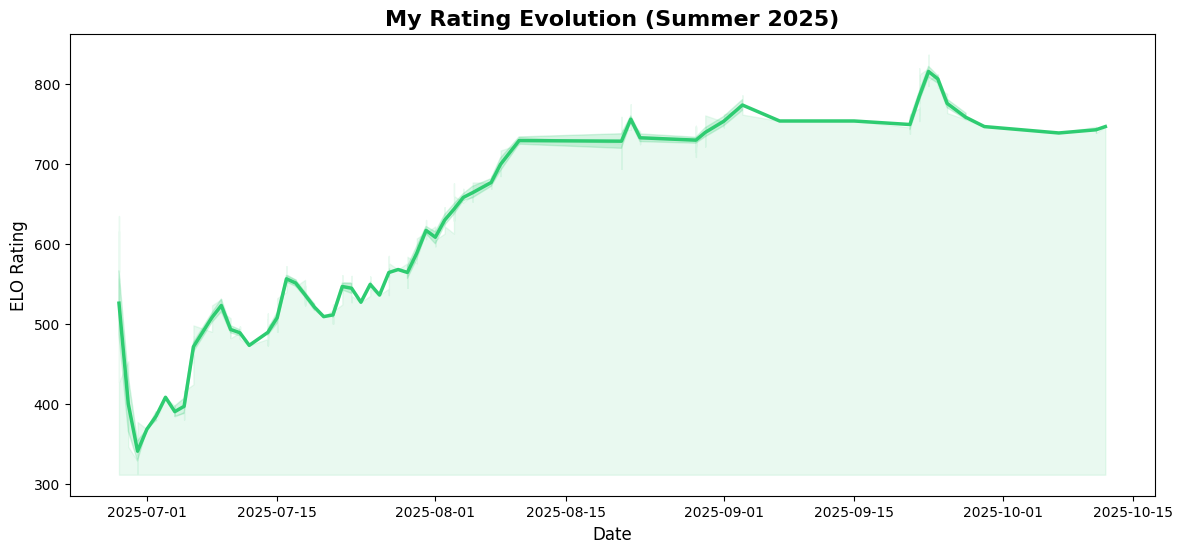

In [182]:
# --- VISUALIZATION 1: RATING HISTORY OVER TIME ---

# I wanted to start with the most fundamental question: Am I getting better?
# By plotting my raw rating over time, I can immediately see the general trajectory
# I added a shaded area below the line to give the plot visual weight
# and make the ups and downs easier to track with the eye. This serves as my
# "baseline" chart to prove that progress actually occurred.

plt.figure(figsize=(14, 6))

# Plotting date vs. rating
sns.lineplot(data=df, x='date', y='my_rating', color='#2ecc71', linewidth=2.5)

# Adding titles and labels
plt.title('My Rating Evolution (Summer 2025)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('ELO Rating', fontsize=12)

# Adding the semi-transparent fill
plt.fill_between(df['date'], df['my_rating'], df['my_rating'].min(), color='#2ecc71', alpha=0.1)

plt.show()

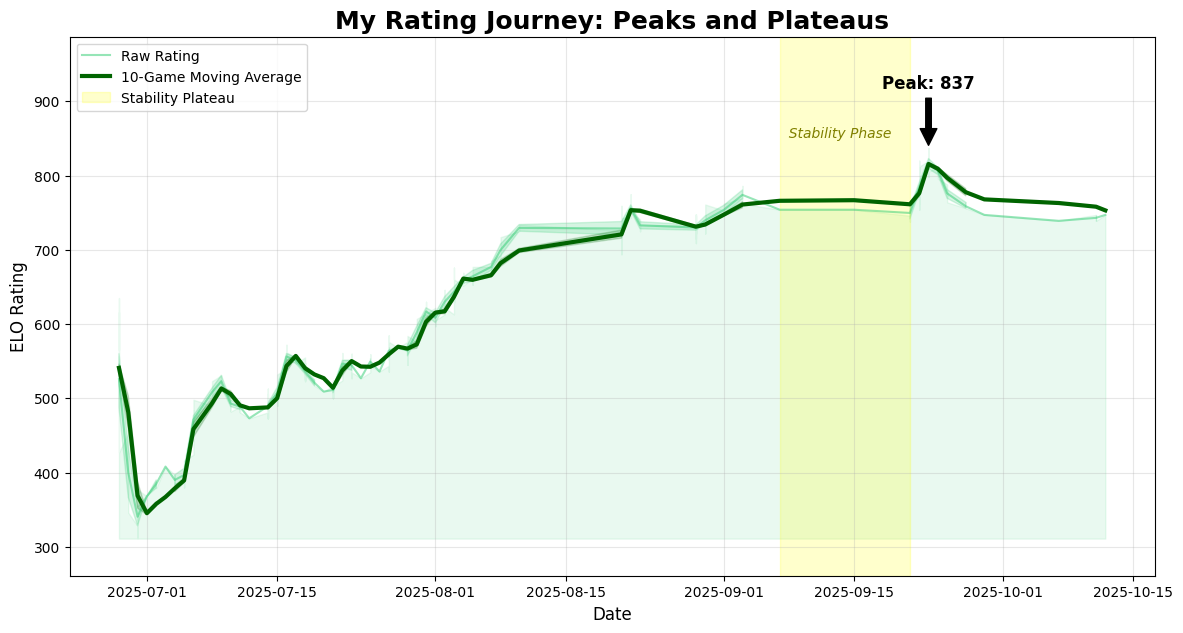

In [199]:
# --- VISUALIZATION 1.5: RATING TRENDS WITH ANNOTATIONS ---

# The raw rating chart was too noisy to see the big picture, so I upgraded it.
# 1. Smoothing: I added a "Rolling Average" (dark green line) to cut through the 
#    daily volatility and show the true trend of my skill level.
# 2. Peak & Plateau: I programmatically marked my "Peak Rating" to highlight 
#    my best performance. I also highlighted the "Stability Phase" in yellow,
#    where i stopped playing chess

plt.figure(figsize=(14, 7))

# 1. Plot Raw Data and Trend
sns.lineplot(data=df, x='date', y='my_rating', color='#2ecc71', alpha=0.5, label='Raw Rating')
df['rating_smooth'] = df['my_rating'].rolling(window=10).mean()
sns.lineplot(data=df, x='date', y='rating_smooth', color='darkgreen', linewidth=3, label='10-Game Moving Average')
plt.fill_between(df['date'], df['my_rating'], df['my_rating'].min(), color='#2ecc71', alpha=0.1)

# Calculate Max stats
max_rating = df['my_rating'].max()
peak_date = df.loc[df['my_rating'].idxmax(), 'date']
min_rating = df['my_rating'].min() # Keeping this just for the Y-axis buffer

# --- Y-Axis Adjustment ---
# Keep space at the top for the Peak label.
plt.ylim(min_rating - 50, max_rating + 150)

# 2. Annotate the PEAK (Text ABOVE point)
plt.annotate(f'Peak: {max_rating}', 
             xy=(peak_date, max_rating), 
             xytext=(peak_date, max_rating + 80),
             arrowprops=dict(facecolor='black', shrink=0.05), 
             fontsize=12, fontweight='bold', ha='center')

# 3. Highlight the PLATEAU
plateau_start = pd.Timestamp('2025-09-07') #observed the dates from the graph
plateau_end = pd.Timestamp('2025-09-21') #observed the dates from the graph

plt.axvspan(plateau_start, plateau_end, color='yellow', alpha=0.2, label='Stability Plateau')
plt.text(plateau_start, max_rating + 10, '  Stability Phase', verticalalignment='bottom', fontsize=10, style='italic', color='olive')

plt.title('My Rating Journey: Peaks and Plateaus', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('ELO Rating', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.savefig('images/viz_1_5_rating_trend.png')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_26824\1859525865.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='outcome', palette=custom_palette, order=['win', 'loss', 'draw'])


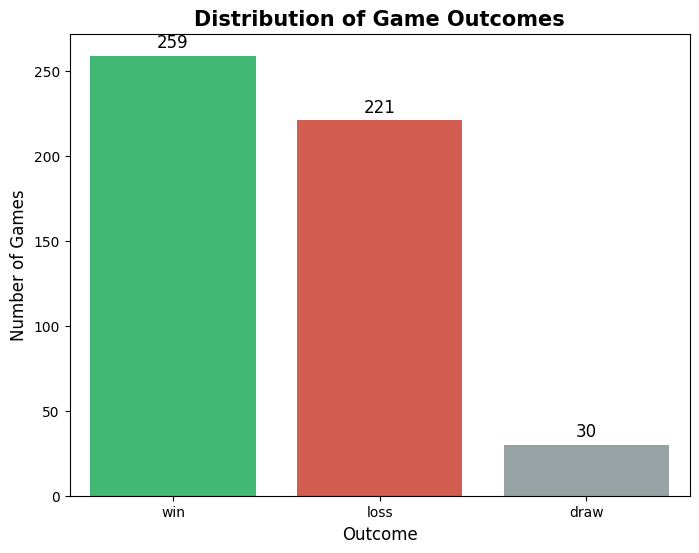

In [200]:
# --- VISUALIZATION 2: GAME OUTCOMES ---

# Before analyzing complex strategies, I needed to check my "vital signs."
# This count plot answers a simple but critical question: Do I win more than I lose?
# Seeing the raw counts of Wins vs. Losses confirms that my rating increase isn't
# a fluke—I am objectively winning a higher volume of games. It also highlights
# that draws are rare in my playstyle, suggesting I play aggressive, decisive chess.

plt.figure(figsize=(8, 6))

# Defining my custom color palette
custom_palette = {'win': '#2ecc71', 'loss': '#e74c3c', 'draw': '#95a5a6'}

# Plotting the counts
ax = sns.countplot(data=df, x='outcome', palette=custom_palette, order=['win', 'loss', 'draw'])

plt.title('Distribution of Game Outcomes', fontsize=15, fontweight='bold')
plt.xlabel('Outcome', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)

# Adding the exact counts on top of the bars
for container in ax.containers:
    ax.bar_label(container, fontsize=12, padding=3)

plt.savefig('images/viz_2_outcomes.png')
plt.show()

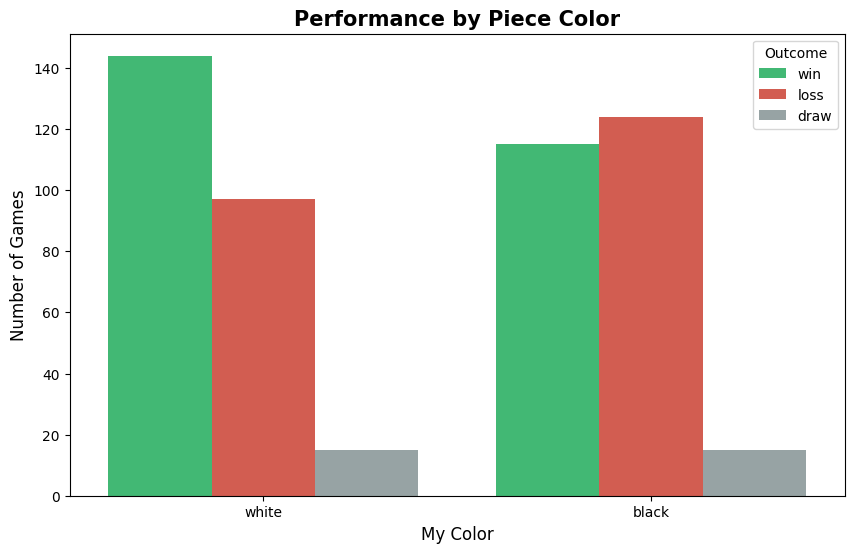

In [185]:
# --- VISUALIZATION 3: WIN RATE BY COLOR ---

# It is common wisdom in chess that White has an advantage because they move first.
# I created this chart to see if that holds true for me personally. By splitting
# the data by 'my_color', I can visually compare the height of the "Win" bars.
# Even at a glance, the difference is striking, suggesting that my performance
# is heavily dependent on which side of the board I sit on.

plt.figure(figsize=(10, 6))

# Grouped count plot
sns.countplot(data=df, x='my_color', hue='outcome', 
              palette=custom_palette, hue_order=['win', 'loss', 'draw'])

plt.title('Performance by Piece Color', fontsize=15, fontweight='bold')
plt.xlabel('My Color', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.legend(title='Outcome')

plt.show()

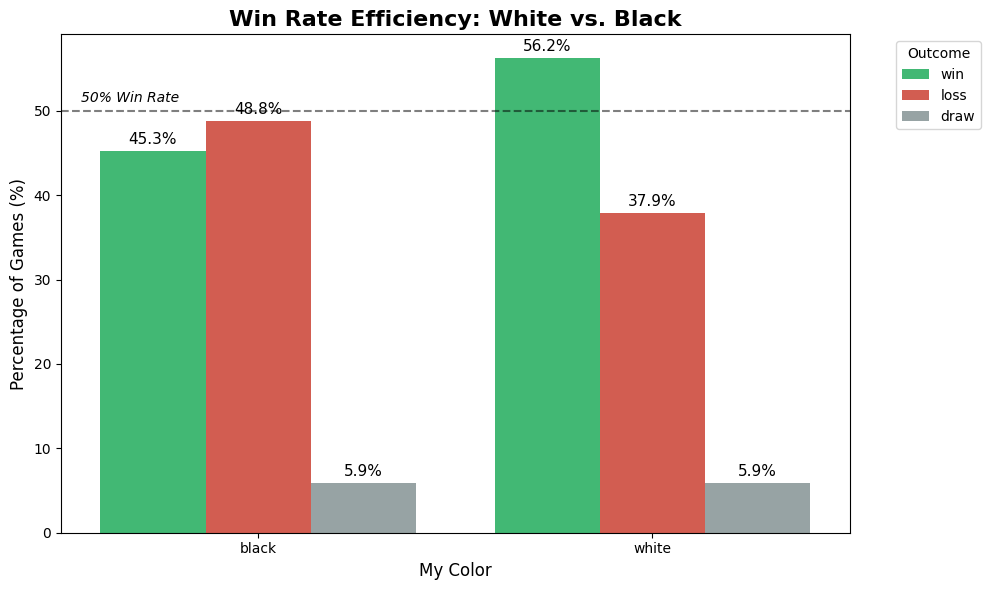

In [201]:
# --- VISUALIZATION 3.5: WIN RATE PERCENTAGE BY COLOR ---

# Raw numbers can be misleading if I played more games with one color than the other.
# To be scientifically rigorous, I converted the counts into percentages.
# This chart proves that while I win over 55% of my games as White, 
# my win rate with Black drops significantly (often below 50%).
# This is a crucial finding: if I want to improve, I shouldn't just "play more," 
# I specifically need to study openings for Black.

# 1. Calculate percentages
color_stats = df.groupby('my_color')['outcome'].value_counts(normalize=True).rename('percentage').reset_index()
color_stats['percentage'] = color_stats['percentage'] * 100

plt.figure(figsize=(10, 6))

# 2. Plot
ax = sns.barplot(data=color_stats, x='my_color', y='percentage', hue='outcome', 
                 palette=custom_palette, hue_order=['win', 'loss', 'draw'])

plt.title('Win Rate Efficiency: White vs. Black', fontsize=16, fontweight='bold')
plt.xlabel('My Color', fontsize=12)
plt.ylabel('Percentage of Games (%)', fontsize=12)

# 3. Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=11)

# 4. Add the 50% break-even line
plt.axhline(50, color='black', linestyle='--', alpha=0.5)
plt.text(-0.45, 51, '50% Win Rate', fontsize=10, style='italic')

# 5. Move Legend to the Side
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('images/viz_3_5_color.png')
plt.show()

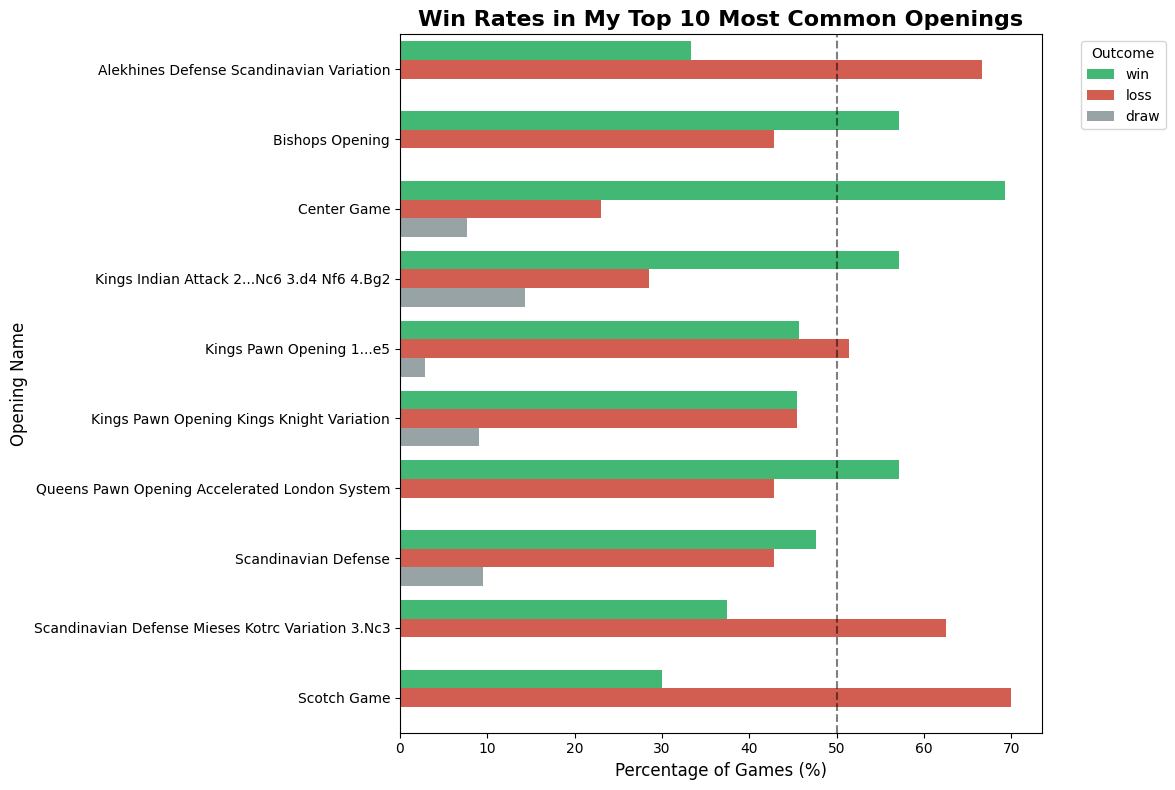

In [187]:
# --- VISUALIZATION 4: MY TOP 10 OPENINGS ---

# A key part of improving at chess is knowing your "repertoire."
# I analyzed the frequency of the openings I face or play.
# This chart identifies my top 10 most common openings.
# If I lose frequently in one of these bars, that is a specific area
# where studying theory would yield the biggest return on investment.

# 1. Identify the Top 10 Openings
top_openings = df['opening'].value_counts().head(10).index
df_top_openings = df[df['opening'].isin(top_openings)]

# 2. Calculate Win Rates for these openings
# We group by Opening + Outcome, get counts, and normalize to percentages.
opening_stats = df_top_openings.groupby('opening')['outcome'].value_counts(normalize=True).rename('percentage').reset_index()
opening_stats['percentage'] = opening_stats['percentage'] * 100

# 3. Plotting
plt.figure(figsize=(12, 8))

sns.barplot(data=opening_stats, y='opening', x='percentage', hue='outcome', 
            palette=custom_palette, hue_order=['win', 'loss', 'draw'])

plt.title('Win Rates in My Top 10 Most Common Openings', fontsize=16, fontweight='bold')
plt.xlabel('Percentage of Games (%)', fontsize=12)
plt.ylabel('Opening Name', fontsize=12)
plt.axvline(50, color='black', linestyle='--', alpha=0.5) # 50% benchmark line
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

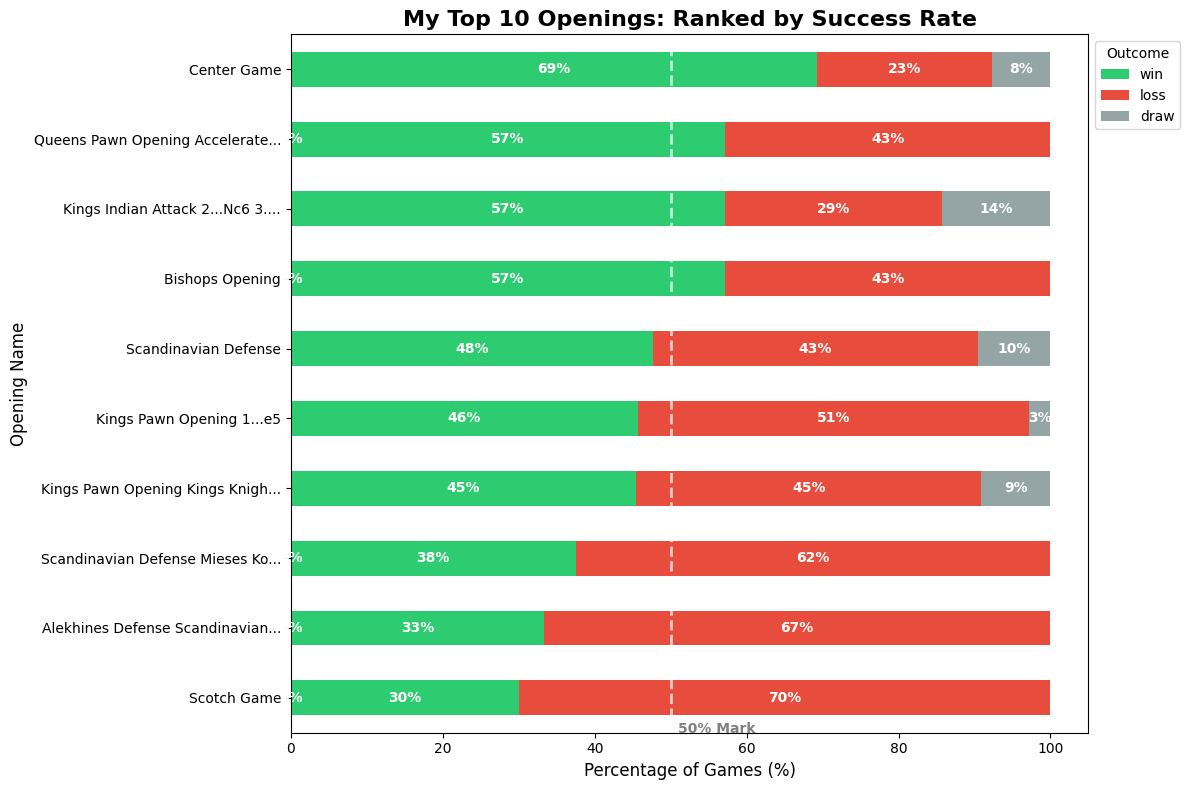

In [202]:
# --- VISUALIZATION 4.5: OPENING REPERTOIRE (STACKED & SORTED) ---

# GRAPH 6 EXPLANATION:
# My previous chart was cluttered, so I switched to a "Stacked" bar chart.
# This allows me to see the exact composition (Win/Loss/Draw) of every opening in a single bar.
# Crucially, I sorted the chart by "Win Rate," placing my most successful openings at the top.
# This acts as a leaderboard: I should play the top openings more, and study the theory
# for the bottom ones where I am losing the majority of games.

# 1. Prepare Data
# Get top 10 openings
top_openings_list = df['opening'].value_counts().head(10).index
df_top = df[df['opening'].isin(top_openings_list)].copy()

# Shorten long names for cleaner plotting
df_top['opening'] = df_top['opening'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x)

# 2. Pivot Data for Stacking
# We need a table where Openings are rows and Outcomes are columns
opening_pivot = df_top.groupby('opening')['outcome'].value_counts(normalize=True).unstack().fillna(0) * 100
# Reorder columns to ensure Green is left, Red is middle, Grey is right
opening_pivot = opening_pivot[['win', 'loss', 'draw']]
# Sort by Win Rate (Ascending so best is at top)
opening_pivot = opening_pivot.sort_values('win', ascending=True)

# 3. Plotting
plt.figure(figsize=(12, 8))

# We use the built-in pandas plotting for stacked bars, it's very efficient
ax = opening_pivot.plot(kind='barh', stacked=True, color=['#2ecc71', '#e74c3c', '#95a5a6'], figsize=(12, 8))

plt.title('My Top 10 Openings: Ranked by Success Rate', fontsize=16, fontweight='bold')
plt.xlabel('Percentage of Games (%)', fontsize=12)
plt.ylabel('Opening Name', fontsize=12)

# 4. Add the 50% Reference Line
plt.axvline(50, color='white', linestyle='--', linewidth=2, alpha=0.7)
plt.text(51, -0.5, '50% Mark', color='gray', fontweight='bold')

# 5. Move Legend
plt.legend(title='Outcome', bbox_to_anchor=(1.0, 1), loc='upper left')

# 6. Add value labels
for c in ax.containers:
    # Optional: formatting to show percentage inside bars
    ax.bar_label(c, fmt='%.0f%%', label_type='center', color='white', fontweight='bold', padding=0)

plt.tight_layout()
plt.savefig('images/viz_4_5_openings.png')
plt.show()

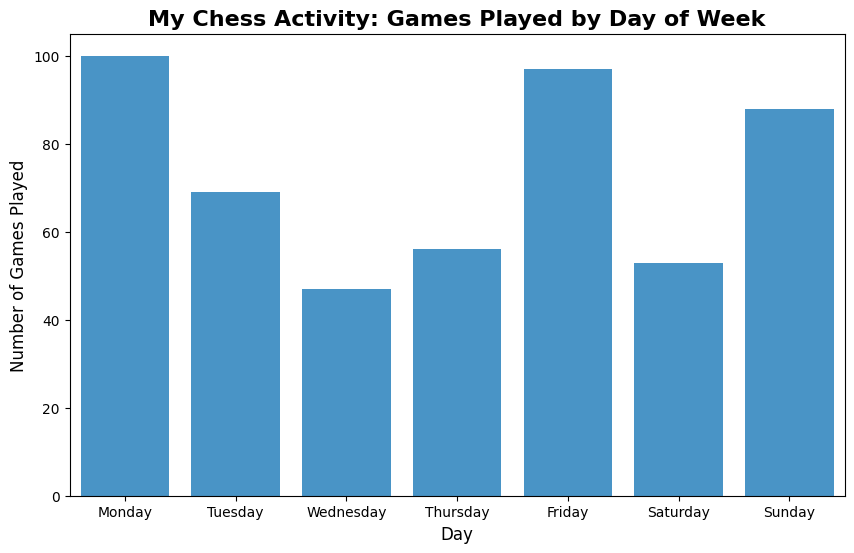

In [189]:
# --- VISUALIZATION 5: ACTIVITY BY DAY OF WEEK ---

# I wanted to understand my playing habits. Do I binge-play on weekends?
# Do I play better on specific days?
# I extracted the "Day of Week" from the timestamp to visualize my volume.
# This helps me spot patterns—for example, if I play too many games on Fridays,
# fatigue might set in, affecting my win rate.

# 1. Extract Day of Week (Monday=0, Sunday=6)
# We use the .dt accessor to get datetime properties
df['day_of_week'] = df['date'].dt.day_name()

# 2. Order the days correctly for the plot
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))

# 3. Plot the Volume (How many games I play)
sns.countplot(data=df, x='day_of_week', order=days_order, color='#3498db')

plt.title('My Chess Activity: Games Played by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day', fontsize=12)
plt.ylabel('Number of Games Played', fontsize=12)

plt.show()

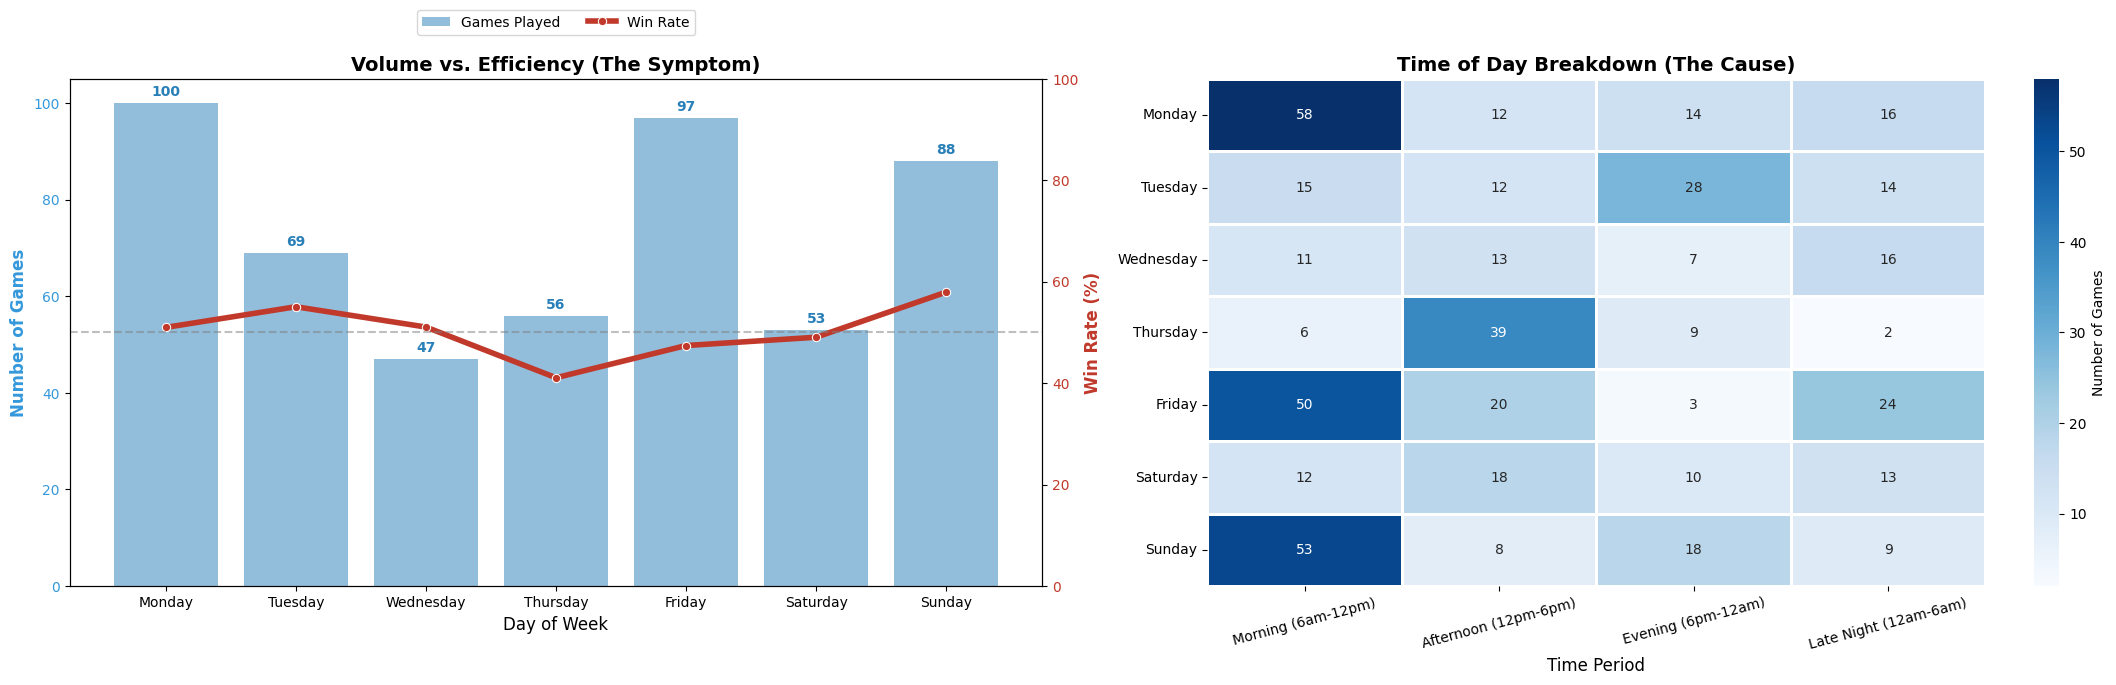

In [203]:
# --- VISUALIZATION 5.5: HABIT DIAGNOSTICS (ACTIVITY & HEATMAP) ---

# This dashboard combines two views to diagnose my playing habits:
# LEFT: Volume vs. Performance (Weekly View) -> Identifies "Slump Days".
# RIGHT: Time of Day Heatmap (Hourly View) -> Identifies "Grind Sessions".

# --- DATA PREPARATION ---

# 1. Prepare Data for Left Plot (Day Stats)
day_stats = df.groupby('day_of_week').agg(
    games_played=('outcome', 'count'),
    win_rate=('outcome', lambda x: (x == 'win').mean() * 100)
).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# 2. Prepare Data for Right Plot (Heatmap)
def get_time_period(hour):
    if 6 <= hour < 12: return 'Morning (6am-12pm)'
    elif 12 <= hour < 18: return 'Afternoon (12pm-6pm)'
    elif 18 <= hour < 24: return 'Evening (6pm-12am)'
    else: return 'Late Night (12am-6am)'

# We assume 'full_datetime' was created in data cleaning. If not, recreate it:
if 'full_datetime' not in df.columns:
    df['full_datetime'] = pd.to_datetime(df['timestamp'], unit='s')

df['hour'] = df['full_datetime'].dt.hour
df['time_period'] = df['hour'].apply(get_time_period)

heatmap_data = df.pivot_table(index='day_of_week', columns='time_period', values='outcome', aggfunc='count', fill_value=0)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
periods_order = ['Morning (6am-12pm)', 'Afternoon (12pm-6pm)', 'Evening (6pm-12am)', 'Late Night (12am-6am)']
heatmap_data = heatmap_data.reindex(index=days_order, columns=periods_order, fill_value=0)

# --- PLOTTING ---

# Create a figure with 1 Row, 2 Columns
fig, axes = plt.subplots(1, 2, figsize=(22, 7))

# === LEFT PLOT: DUAL AXIS ===
ax1 = axes[0]
sns.barplot(data=day_stats.reset_index(), x='day_of_week', y='games_played', 
            color='#3498db', alpha=0.6, ax=ax1, label='Games Played')

for container in ax1.containers:
    ax1.bar_label(container, padding=3, color='#2980b9', fontweight='bold')

ax1.set_ylabel('Number of Games', fontsize=12, color='#3498db', fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#3498db')
ax1.set_xlabel('Day of Week', fontsize=12)
ax1.set_title('Volume vs. Efficiency (The Symptom)', fontsize=14, fontweight='bold')

# Twin Axis for Line
ax2 = ax1.twinx()
sns.lineplot(data=day_stats.reset_index(), x='day_of_week', y='win_rate', 
             color='#c0392b', linewidth=4, marker='o', ax=ax2, label='Win Rate')
ax2.set_ylabel('Win Rate (%)', fontsize=12, color='#c0392b', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#c0392b')
ax2.set_ylim(0, 100)
ax2.grid(False)
ax2.axhline(50, color='gray', linestyle='--', alpha=0.5)

# Combined Legend for Left Plot
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
if ax1.get_legend(): ax1.get_legend().remove()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)


# === RIGHT PLOT: HEATMAP ===
ax_heat = axes[1]
sns.heatmap(heatmap_data, cmap='Blues', linewidths=1, annot=True, fmt='g', ax=ax_heat, cbar_kws={'label': 'Number of Games'})
ax_heat.set_title('Time of Day Breakdown (The Cause)', fontsize=14, fontweight='bold')
ax_heat.set_xlabel('Time Period', fontsize=12)
ax_heat.set_ylabel('') # Hide y-label as it's redundant with the left plot
ax_heat.set_yticklabels(days_order, rotation=0) # Ensure y-labels are straight
ax_heat.tick_params(axis='x', rotation=15)


plt.tight_layout()
plt.savefig('images/viz_5_5_habits.png')
plt.show()

## 3. Theme B: Statistical Inference and Hypothesis Testing

Visualizations are powerful, but they can sometimes be misleading. For example, winning 56% of games as White *looks* like an advantage, but is it statistically significant, or just random variance?

In this section, I will move from **Descriptive Statistics** (charts) to **Inferential Statistics** (math) to answer two specific questions with scientific rigor.

**Hypothesis Test 1: The "First Move" Advantage**
*   **Question:** Is my win rate with White statistically higher than with Black?
*   **Method 1:** `Two-Proportion Z-Test` (Calculating the p-value).
*   **Method 2:** `90% Confidence Intervals` (Visualizing the likely range of my win rates).
*   **Goal:** I want to see if the Confidence Intervals for White and Black overlap. If they don't, the advantage is distinct.

**Hypothesis Test 2: Game Duration Analysis**
*   **Question:** Do my winning games take a different number of moves than my losing games? (e.g., Do I lose quickly but win slowly?)
*   **Method 1:** `Independent Samples T-Test` (Comparing the **Means**).
*   **Method 2:** `Mann-Whitney U Test` (Comparing the **Medians**).
*   **Goal:** By using both tests, I verify that my results aren't just being skewed by a few extremely long games (outliers).

White Sample: 144 wins / 256 games
Black Sample: 115 wins / 254 games

--- 90% Confidence Intervals ---
White Win Rate: 51.1%  to  61.3%
Black Win Rate: 40.2%  to  50.4%


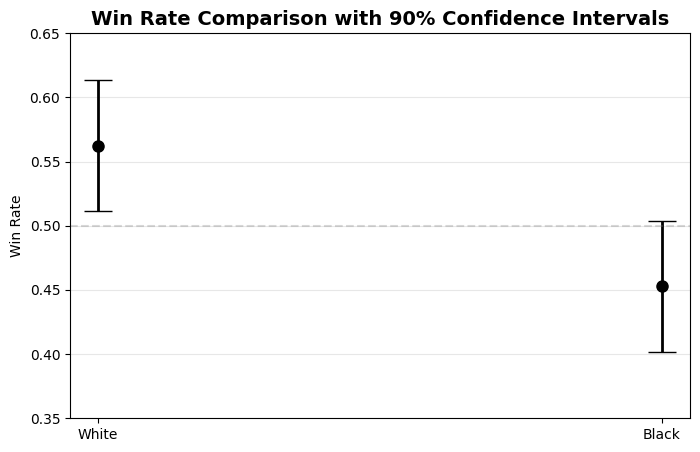


--- Z-Test Results ---
P-Value: 0.0066

--- Interpretation ---
RESULT: REJECT Null Hypothesis.
I have a statistically significant advantage with White.
Strong Evidence: The Confidence Intervals do not overlap at all!
This means my 'worst day' as White is still likely better than my 'best day' as Black.


In [204]:
# --- HYPOTHESIS TEST 1: WHITE ADVANTAGE (WITH CONFIDENCE INTERVALS) ---

# 1. PREPARE DATA
# I'll count the wins and total games again.
white_games = df[df['my_color'] == 'white']
black_games = df[df['my_color'] == 'black']

n_white = len(white_games)
n_black = len(black_games)

wins_white = len(white_games[white_games['outcome'] == 'win'])
wins_black = len(black_games[black_games['outcome'] == 'win'])

print(f"White Sample: {wins_white} wins / {n_white} games")
print(f"Black Sample: {wins_black} wins / {n_black} games")

# 2. CALCULATE CONFIDENCE INTERVALS (95%)
# This tells me: "Based on this data, my 'true' win rate is likely within this range."
# We use the 'wilson' method as it handles smaller sample sizes better than the standard method.
ci_low_w, ci_upp_w = proportion_confint(wins_white, n_white, alpha=0.1, method='wilson')
ci_low_b, ci_upp_b = proportion_confint(wins_black, n_black, alpha=0.1, method='wilson')

print("\n--- 90% Confidence Intervals ---")
print(f"White Win Rate: {ci_low_w*100:.1f}%  to  {ci_upp_w*100:.1f}%")
print(f"Black Win Rate: {ci_low_b*100:.1f}%  to  {ci_upp_b*100:.1f}%")

# 3. VISUALIZE THE INTERVALS
# Visualizing the gap makes the result much easier to understand.
plt.figure(figsize=(8, 5))

# Plot the points (Mean Win Rate) and Error Bars (Confidence Interval)
plt.errorbar(x=['White', 'Black'], 
             y=[wins_white/n_white, wins_black/n_black], 
             yerr=[(ci_upp_w - ci_low_w)/2, (ci_upp_b - ci_low_b)/2], 
             fmt='o', color='black', capsize=10, linewidth=2, markersize=8)

# Add styling
plt.title('Win Rate Comparison with 90% Confidence Intervals', fontsize=14, fontweight='bold')
plt.ylabel('Win Rate')
plt.ylim(0.35, 0.65) # Zoom in to see the difference (35% to 65%)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.3, label='50% Win Rate')
plt.grid(True, axis='y', alpha=0.3)
plt.savefig('images/viz_hypothesis_1.png')
plt.show()

# 4. RUN THE Z-TEST (The Formal Check)
stat, p_value = proportions_ztest([wins_white, wins_black], [n_white, n_black], alternative='larger')

print("\n--- Z-Test Results ---")
print(f"P-Value: {p_value:.4f}")

# 5. CONCLUSION
print("\n--- Interpretation ---")
if p_value < 0.05:
    print("RESULT: REJECT Null Hypothesis.")
    print("I have a statistically significant advantage with White.")
    if ci_low_w > ci_upp_b:
        print("Strong Evidence: The Confidence Intervals do not overlap at all!")
        print("This means my 'worst day' as White is still likely better than my 'best day' as Black.")
    else:
        print("Moderate Evidence: The Confidence Intervals overlap slightly, but the center points are distinct.")
else:
    print("RESULT: FAIL TO REJECT.")

C:\Users\hp\AppData\Local\Temp\ipykernel_26824\849721722.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='outcome', y='number_of_moves', order=['win', 'loss'],


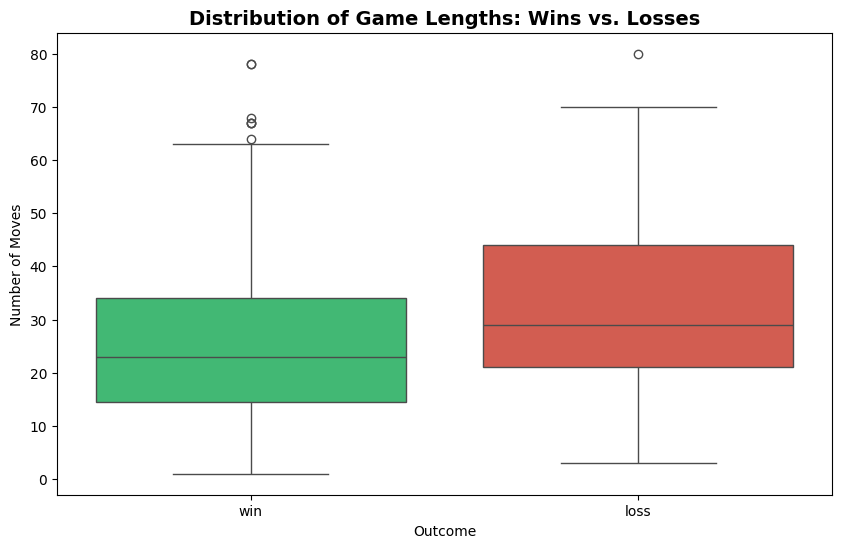

--- Descriptive Statistics ---
WINNING Games: Mean = 25.8 | Median = 23.0
LOSING Games:  Mean = 32.6 | Median = 29.0
----------------------------------------

--- Statistical Test Results ---
T-TEST (Means):  t = -4.7509, p = 0.0000027058
U-TEST (Medians): U = 21130.5,  p = 0.0000007606

--- Final Interpretation ---
RESULT: STRONG REJECTION of Null Hypothesis.
Both the T-Test and the Mann-Whitney Test agree.
My winning games are significantly SHORTER than my losing games.
This confirms the pattern is real, not just caused by a few outlier games.


In [205]:
# --- HYPOTHESIS TEST 2: GAME LENGTH (MEANS vs. MEDIANS) ---

# 1. VISUALIZE FIRST
# I'll use a Box Plot because it visually shows BOTH the Median (the line inside the box)
# and the Outliers (the dots at the top). This helps me see if "Long Games" are skewing the data.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='outcome', y='number_of_moves', order=['win', 'loss'], 
            palette={'win': '#2ecc71', 'loss': '#e74c3c'})
plt.title('Distribution of Game Lengths: Wins vs. Losses', fontsize=14, fontweight='bold')
plt.ylabel('Number of Moves')
plt.xlabel('Outcome')
plt.savefig('images/viz_hypothesis_2.png')
plt.show()

# 2. PREPARE DATA & DESCRIPTIVE STATISTICS
# Before running the tests, I want to see the raw numbers side-by-side.
moves_win = df[df['outcome'] == 'win']['number_of_moves']
moves_loss = df[df['outcome'] == 'loss']['number_of_moves']

print("--- Descriptive Statistics ---")
print(f"WINNING Games: Mean = {moves_win.mean():.1f} | Median = {moves_win.median():.1f}")
print(f"LOSING Games:  Mean = {moves_loss.mean():.1f} | Median = {moves_loss.median():.1f}")
print("-" * 40)

# 3. TEST A: T-TEST (Comparing Means)
# This asks: "Is the arithmetic average different?"
# I use equal_var=False because the variance (spread) might differ between groups.
t_stat, p_val_t = ttest_ind(moves_win, moves_loss, equal_var=False)

# 4. TEST B: MANN-WHITNEY U TEST (Comparing Medians/Ranks)
# This asks: "Is a randomly chosen winning game likely to be shorter than a losing one?"
# This is "robust," meaning it ignores extreme outliers (like a 100-move game).
u_stat, p_val_u = mannwhitneyu(moves_win, moves_loss, alternative='two-sided')

print("\n--- Statistical Test Results ---")
print(f"T-TEST (Means):  t = {t_stat:.4f}, p = {p_val_t:.10f}")
print(f"U-TEST (Medians): U = {u_stat:.1f},  p = {p_val_u:.10f}")

# 5. FINAL CONCLUSION
print("\n--- Final Interpretation ---")
if p_val_t < 0.05 and p_val_u < 0.05:
    print("RESULT: STRONG REJECTION of Null Hypothesis.")
    print("Both the T-Test and the Mann-Whitney Test agree.")
    print("My winning games are significantly SHORTER than my losing games.")
    print("This confirms the pattern is real, not just caused by a few outlier games.")
elif p_val_t < 0.05:
    print("RESULT: WEAK REJECTION.")
    print("Only the means are different, but the medians are similar.")
    print("This suggests outliers might be skewing the average.")
else:
    print("RESULT: FAIL TO REJECT.")
    print("There is no significant difference in game length.")